In [1]:
import pandas as pd
import mlflow
import dagshub
%matplotlib inline
import matplotlib.pyplot as plt

from tfg_module import my_get_time_series as mgts
from tfg_module import my_azure as maz

In [2]:
dagshub.init(repo_owner='JCOQUE', repo_name='TFG-ingenieria', mlflow=True) 
mlflow.set_tracking_uri('https://dagshub.com/JCOQUE/TFG-ingenieria.mlflow')

Initialized MLflow to track repo "JCOQUE/TFG-ingenieria"

Repository JCOQUE/TFG-ingenieria initialized!

In [3]:
def get_mlflow_pred(url):
    mlflow_pred_csv = mlflow.artifacts.download_artifacts(url)
    mlflow_pred = pd.read_csv(mlflow_pred_csv)
    mlflow_pred.drop(columns = ['Unnamed: 0'], inplace = True)
    return  mlflow_pred

In [4]:
def transform_dataset(dataset):
    dataset = dataset.loc[1:4, :].copy() # only getting the first 4 months, i.e. test size
    dataset['date'] = pd.to_datetime(dataset['date'], format= '%Y-%m-%d')
    dataset['pred'] = dataset['pred'].astype('float32')
    return  dataset

## Compras

In [5]:
train_ts_compras = mgts.get_ts('Compras', type = 'train')
train_ts_compras

,date,Compras
0,2017-09-30,"6,865"
1,2017-10-31,"5,452"
2,2017-11-30,"4,399"
3,2017-12-31,"37,490"
4,2018-01-31,"4,486"
...,...,...
71,2023-08-31,"17,181"
72,2023-09-30,"7,394"
73,2023-10-31,"28,417"
74,2023-11-30,"14,432"


In [6]:
test_ts_compras = mgts.get_ts('Compras', type = 'test')
test_ts_compras

,date,Compras
0,2024-01-31,"13,777"
1,2024-02-29,"10,422"
2,2024-03-31,"17,173"
3,2024-04-30,"27,871"
4,2024-05-31,268


In [7]:
# month of may gets discarded
test_ts_compras = test_ts_compras.loc[0:3,:]
test_ts_compras

,date,Compras
0,2024-01-31,"13,777"
1,2024-02-29,"10,422"
2,2024-03-31,"17,173"
3,2024-04-30,"27,871"


In [8]:
TCN_compras_mae = get_mlflow_pred('mlflow-artifacts:/e4812a076abd4294b4e238dc8106ce47/8730015f2bd340acb9fce3c112ee156e/artifacts/predictions/TCN_Compras_best_mae.csv')
TCN_compras_mae = transform_dataset(TCN_compras_mae)
TCN_compras_mae

,date,pred
1,2024-01-31,"25,748"
2,2024-02-29,"17,536"
3,2024-03-31,"10,893"
4,2024-04-30,"23,823"


In [9]:
TCN_compras_rmse = get_mlflow_pred('mlflow-artifacts:/e4812a076abd4294b4e238dc8106ce47/5f97f5a5d02e42c8b8c4e7aebdf81d0c/artifacts/predictions/TCN_Compras_best_rmse.csv')
TCN_compras_rmse = transform_dataset(TCN_compras_rmse)
TCN_compras_rmse

,date,pred
1,2024-01-31,"20,878"
2,2024-02-29,"18,403"
3,2024-03-31,"11,599"
4,2024-04-30,"18,260"


In [10]:
lgbm_compras_mae = get_mlflow_pred('mlflow-artifacts:/25707a52310b4902beafe11b4d03a4e7/cd14bf171ef14dd1a60d9d1847c9200e/artifacts/predictions/LightGBM_Compras_best_mae.csv')
lgbm_compras_mae = transform_dataset(lgbm_compras_mae)
lgbm_compras_mae

,date,pred
1,2024-01-31,"13,686"
2,2024-02-29,"9,099"
3,2024-03-31,"17,446"
4,2024-04-30,"15,040"


In [11]:
lgbm_compras_rmse = get_mlflow_pred('mlflow-artifacts:/25707a52310b4902beafe11b4d03a4e7/5e2f4a6d16b54d8cb22e003ac6913abb/artifacts/predictions/LightGBM_Compras_best_rmse.csv')
lgbm_compras_rmse = transform_dataset(lgbm_compras_rmse)
lgbm_compras_rmse

,date,pred
1,2024-01-31,"13,771"
2,2024-02-29,"9,413"
3,2024-03-31,"17,157"
4,2024-04-30,"9,732"


Siempre debe haber un conjunto de *test* para poder evaluar un modelo. En este caso, una pena que los modelos de XGBoost e Informer haya sido inviable por falta de tiempo pero, sobre todo de recursos llevar a cabo su entrenamiento. Con esto dicho, dado que los mejores modelos obtenidos en cada algortimo para cada métrica (MAE y RMSE) son muy parecidos, se van a comparar los 4 modelos de compras:
* TCN compras best_MAE
* TCN compras best_RMSE
* LightGBM compras best_MAE
* LightGBM compras best_RMSE

<p align="center">
  <img src="../../Memoria/imgs/metrics_compras_tcn.png" alt="Imagen 1" width="45%" style="margin-right: 10px;">
  <img src="../../Memoria/imgs/metrics_compras_lgbm.png" alt="Imagen 2" width="45%">
</p>

Con un simple vistazo a las métricas se puede ver que TCN tiene unas métricas mucho mejores: en MAE, pero sobre todo en RMSE. Estas métricas vienen bien para poder comparar modelos entre sí, pero de todas maneras siempre es necesario graficar sus  resultados predichos con el conjunto de *test* y determinar si algún algoritmos, independientemente de sus métrica, ha conseguido encontrar algún patrón en la serie temporal y se ajusta a la tendencia y estacionalidad que la serie temporal pueda presentar.

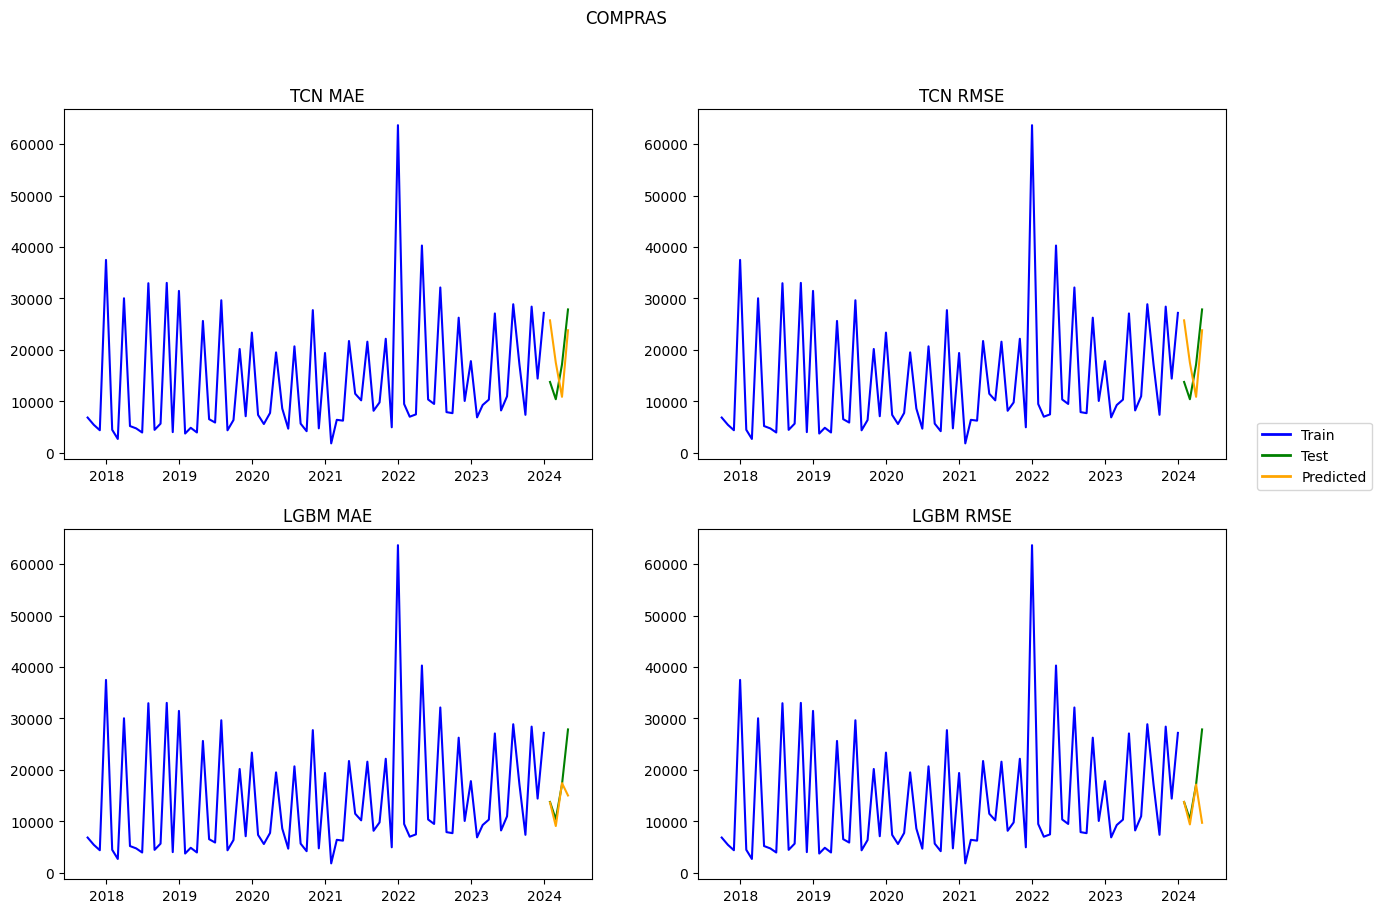

In [12]:
plt.close() # since  in the my_future.py I have the next line: matplotlib.use('Agg'), I need to ensrue plt is empty before plotting
fig, ax = plt.subplots(2,2, figsize = (15,10))

ax[0,0].plot(train_ts_compras['date'], train_ts_compras['Compras'], color = 'blue')
ax[0,0].plot(test_ts_compras['date'], test_ts_compras['Compras'], color = 'green')
ax[0,0].plot(TCN_compras_mae['date'], TCN_compras_mae['pred'], color = 'orange')
ax[0,0].set_title('TCN MAE')

ax[0,1].plot(train_ts_compras['date'], train_ts_compras['Compras'], color = 'blue')
ax[0,1].plot(test_ts_compras['date'], test_ts_compras['Compras'], color = 'green')
ax[0,1].plot(TCN_compras_mae['date'], TCN_compras_mae['pred'], color = 'orange')
ax[0,1].set_title('TCN RMSE')

ax[1,0].plot(train_ts_compras['date'], train_ts_compras['Compras'], color = 'blue')
ax[1,0].plot(test_ts_compras['date'], test_ts_compras['Compras'], color = 'green')
ax[1,0].plot(lgbm_compras_mae['date'], lgbm_compras_mae['pred'], color = 'orange')
ax[1,0].set_title('LGBM MAE')

ax[1,1].plot(train_ts_compras['date'], train_ts_compras['Compras'], color = 'blue')
ax[1,1].plot(test_ts_compras['date'], test_ts_compras['Compras'], color = 'green')
ax[1,1].plot(lgbm_compras_rmse['date'], lgbm_compras_rmse['pred'], color = 'orange')
ax[1,1].set_title('LGBM RMSE')

plt.suptitle('COMPRAS')
lines = [plt.Line2D([0], [0], color='blue', lw=2),
         plt.Line2D([0], [0], color='green', lw=2),
         plt.Line2D([0], [0], color='orange', lw=2)]
labels = ['Train', 'Test', 'Predicted']

fig.legend(lines, labels, loc='center right')

plt.show()

Como era de esperar, TCN se ajusta mucho mejor (y de manera muy precisa) a las compras de los siguientes cuatro meses. Sin embargo, por la otra parte, LightGBM parece también haber encontrado el patrón pero de manera más tímida. Con las métricas mostradas en la imagen anterior junto cono estas gráficas, se puede determinar que el algoritmo TCN parece ser más viable en esta situación que el algoritmo de LightGBM. Dado que ambos modelos, TCN compras best_MAE y TCN compras best_RMSE son tan parecidos, con métricas tan paredicas y predicciones tan parecidas, se va a elegir TCN compras RMSE que parece que se ajusta ligeramente mejor a los datos de testeo.

In [13]:
modelo_compras_elegido = get_mlflow_pred('mlflow-artifacts:/e4812a076abd4294b4e238dc8106ce47/5f97f5a5d02e42c8b8c4e7aebdf81d0c/artifacts/predictions/TCN_Compras_best_rmse.csv')
modelo_compras_elegido = modelo_compras_elegido.loc[5:7, :].copy() #Se predicen los siguientes tres meses
modelo_compras_elegido['date'] = pd.to_datetime(modelo_compras_elegido['date'], format= '%Y-%m-%d')
modelo_compras_elegido['pred'] = modelo_compras_elegido['pred'].astype('float32')
modelo_compras_elegido

,date,pred
5,2024-05-31,"20,599"
6,2024-06-30,"14,027"
7,2024-07-31,"17,243"


## Ventas

In [13]:
train_ts_ventas = mgts.get_ts('Ventas', type = 'train')
train_ts_ventas

,date,Ventas
0,2017-09-30,"5,783"
1,2017-10-31,"20,854"
2,2017-11-30,"14,191"
3,2017-12-31,"7,595"
4,2018-01-31,"12,358"
...,...,...
71,2023-08-31,"13,443"
72,2023-09-30,"16,520"
73,2023-10-31,"17,195"
74,2023-11-30,"13,819"


In [14]:
test_ts_ventas = mgts.get_ts("Ventas", type = 'test')
test_ts_ventas

,date,Ventas
0,2024-01-31,"26,512"
1,2024-02-29,"22,967"
2,2024-03-31,"18,972"
3,2024-04-30,"17,455"
4,2024-05-31,0


In [15]:
# month of may gets discarded
test_ts_ventas = test_ts_ventas.loc[0:3,:]
test_ts_ventas

,date,Ventas
0,2024-01-31,"26,512"
1,2024-02-29,"22,967"
2,2024-03-31,"18,972"
3,2024-04-30,"17,455"


In [16]:
TCN_ventas_mae = get_mlflow_pred('mlflow-artifacts:/24b7234b0fc04727a39b4e7add015333/d802db2669a24302aa62d6d97d20c621/artifacts/predictions/TCN_Ventas_best_mae.csv')
TCN_ventas_mae = transform_dataset(TCN_ventas_mae)
TCN_ventas_mae

,date,pred
1,2024-01-31,"14,482"
2,2024-02-29,"14,675"
3,2024-03-31,"14,857"
4,2024-04-30,"15,049"


In [17]:
TCN_ventas_rmse = get_mlflow_pred('mlflow-artifacts:/24b7234b0fc04727a39b4e7add015333/702d3fede7044069ae4522a1d9fba86d/artifacts/predictions/TCN_Ventas_best_rmse.csv')
TCN_ventas_rmse = transform_dataset(TCN_ventas_rmse)
TCN_ventas_rmse

,date,pred
1,2024-01-31,"13,355"
2,2024-02-29,"13,028"
3,2024-03-31,"12,743"
4,2024-04-30,"12,466"


In [18]:
lgbm_ventas_mae = get_mlflow_pred('mlflow-artifacts:/703c637793b24acb87079f949bd98ee1/ee8bd97b8a6e4d78925b4d62e9011957/artifacts/predictions/LightGBM_Ventas_best_mae.csv')
lgbm_ventas_mae = transform_dataset(lgbm_ventas_mae)
lgbm_ventas_mae

,date,pred
1,2024-01-31,"14,252"
2,2024-02-29,"14,252"
3,2024-03-31,"14,252"
4,2024-04-30,"14,252"


In [19]:
lgbm_ventas_rmse = get_mlflow_pred('mlflow-artifacts:/703c637793b24acb87079f949bd98ee1/d3a2dc8cdfd64e239205abca345c18a2/artifacts/predictions/LightGBM_Ventas_best_rmse.csv')
lgbm_ventas_rmse = transform_dataset(lgbm_ventas_rmse)
lgbm_ventas_rmse

,date,pred
1,2024-01-31,"14,278"
2,2024-02-29,"14,278"
3,2024-03-31,"14,278"
4,2024-04-30,"14,278"


Al igual que antes, se van a comparar los mismos algoritmos, con los mismos criterios anteriormente dichos
* TCN ventas best_MAE
* TCN ventas best_RMSE
* LightGBM ventas best_MAE
* LightGBM ventas best_RMSE

<p align="center">
  <img src="../../Memoria/imgs/metrics_ventas_tcn.png" alt="Imagen 1" width="45%" style="margin-right: 10px;">
  <img src="../../Memoria/imgs/metrics_ventas_lgbm.png" alt="Imagen 2" width="45%">
</p>

En una primera instancia, por el valor de las métricas, parece que TCN ventas best_MAE es el mejor modelo. De nuevo, al igual que antes, se grafican los resultados predichos con los reales para ver si algún algoritmo ha conseguido aprender la tendencia o estacionalidad de la serie temporal de ventas.

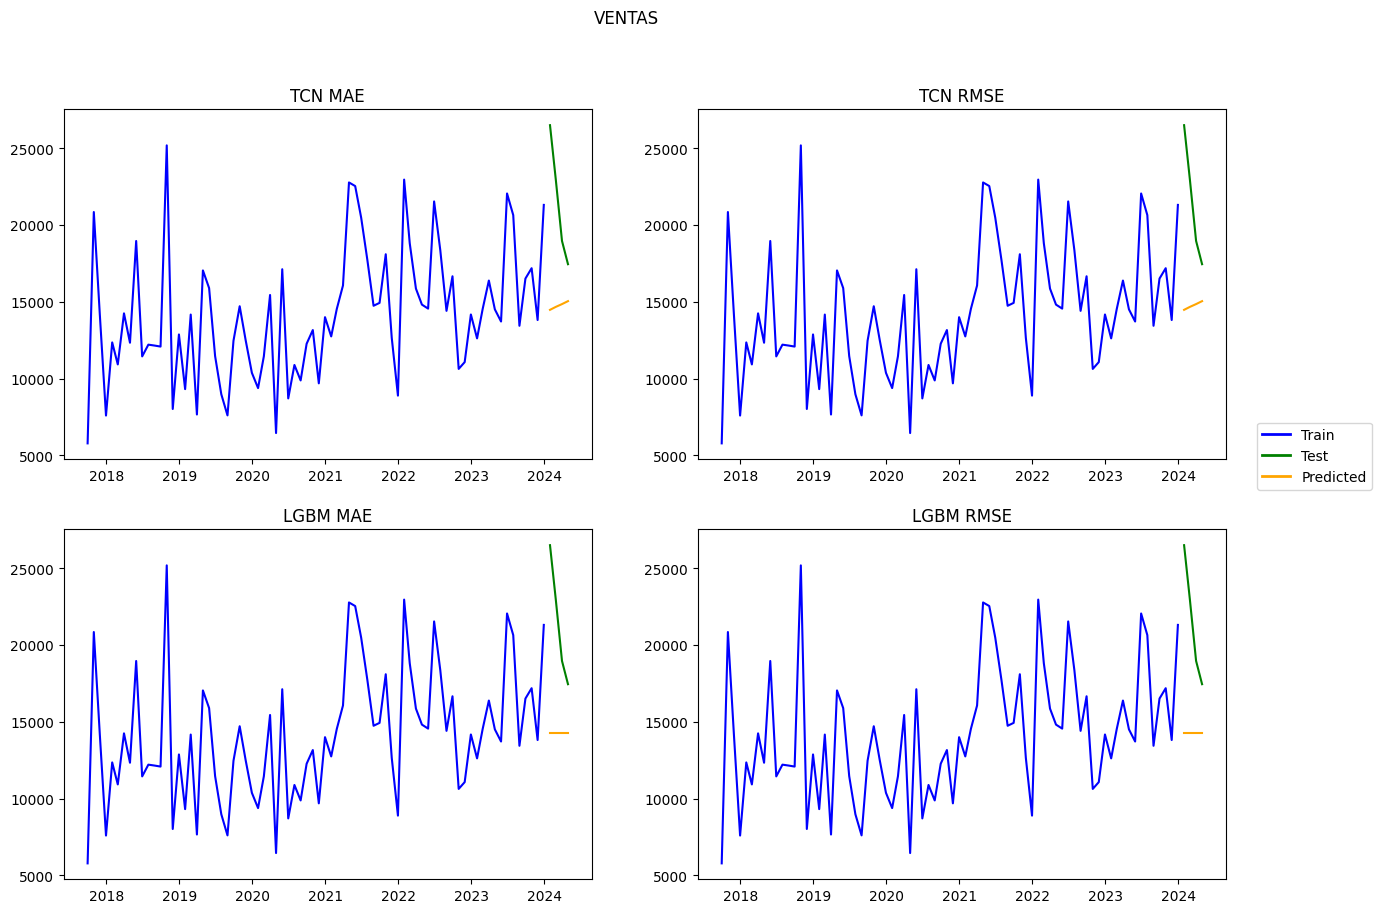

In [20]:
plt.close() # since  in the my_future.py I have the next line: matplotlib.use('Agg'), I need to ensrue plt is empty before plotting
fig, ax = plt.subplots(2,2, figsize = (15,10))

ax[0,0].plot(train_ts_ventas['date'], train_ts_ventas['Ventas'], color = 'blue')
ax[0,0].plot(test_ts_ventas['date'], test_ts_ventas['Ventas'], color = 'green')
ax[0,0].plot(TCN_ventas_mae['date'], TCN_ventas_mae['pred'], color = 'orange')
ax[0,0].set_title('TCN MAE')

ax[0,1].plot(train_ts_ventas['date'], train_ts_ventas['Ventas'], color = 'blue')
ax[0,1].plot(test_ts_ventas['date'], test_ts_ventas['Ventas'], color = 'green')
ax[0,1].plot(TCN_ventas_mae['date'], TCN_ventas_mae['pred'], color = 'orange')
ax[0,1].set_title('TCN RMSE')

ax[1,0].plot(train_ts_ventas['date'], train_ts_ventas['Ventas'], color = 'blue')
ax[1,0].plot(test_ts_ventas['date'], test_ts_ventas['Ventas'], color = 'green')
ax[1,0].plot(lgbm_ventas_mae['date'], lgbm_ventas_mae['pred'], color = 'orange')
ax[1,0].set_title('LGBM MAE')

ax[1,1].plot(train_ts_ventas['date'], train_ts_ventas['Ventas'], color = 'blue')
ax[1,1].plot(test_ts_ventas['date'], test_ts_ventas['Ventas'], color = 'green')
ax[1,1].plot(lgbm_ventas_rmse['date'], lgbm_ventas_rmse['pred'], color = 'orange')
ax[1,1].set_title('LGBM RMSE')

plt.suptitle('VENTAS')

lines = [plt.Line2D([0], [0], color='blue', lw=2),
         plt.Line2D([0], [0], color='green', lw=2),
         plt.Line2D([0], [0], color='orange', lw=2)]
labels = ['Train', 'Test', 'Predicted']

fig.legend(lines, labels, loc='center right')

plt.show()

En este caso, no parece que ninguno de los modelos haya conseguido encontrar ningún patrón, ni se ajuste bien a la tendencia de la serie temporal. Un esudio en profundidad y análisis de los modelos, más entrenamiento, otros enfoques y más y mejores recursos serían necesarios para poder obtener unos resultados mejores. Se elige el modelo TCN ventas best_MAE como "el mejor modelo" de los cuatro y será el que se use en las predicciones  del dashboard.

In [22]:
modelo_ventas_elegido = get_mlflow_pred('mlflow-artifacts:/24b7234b0fc04727a39b4e7add015333/d802db2669a24302aa62d6d97d20c621/artifacts/predictions/TCN_Ventas_best_mae.csv')
modelo_ventas_elegido = modelo_ventas_elegido.loc[5:7, :].copy() #Se predicen los siguientes tres meses
modelo_ventas_elegido['date'] = pd.to_datetime(modelo_ventas_elegido['date'], format= '%Y-%m-%d')
modelo_ventas_elegido['pred'] = modelo_ventas_elegido['pred'].astype('float32')
modelo_ventas_elegido

,date,pred
5,2024-05-31,"15,247"
6,2024-06-30,"15,447"
7,2024-07-31,"15,650"


In [23]:
# this is the dataset that will be pushed to Azure and used by Power BI
final_data =maz.prepare_push_dataset(modelo_compras_elegido,
                          modelo_ventas_elegido)
final_data

,ID,Fecha,Cuenta,NoCuenta,Debe,Haber,Entidad,Compras,Ventas,NoGrupo,type
0,0,25/09/2017,Capital social,100,0,"1,500",Allison Hill,0,0,100,Actual
1,1,25/09/2017,BBVA,572,"1,500",0,Allison Hill,0,0,500,Actual
2,2,25/09/2017,Capital social,100,0,"1,500",Noah Rhodes,0,0,100,Actual
3,3,25/09/2017,BBVA,572,"1,500",0,Noah Rhodes,0,0,500,Actual
4,4,25/09/2017,Acreedores por prestaciones de servicios (euros),410,0,223,Angie Henderson,0,0,400,Actual
...,...,...,...,...,...,...,...,...,...,...,...
39676,39676,31/05/2024,missing,missing,0,0,missing,0,"15,247",missing,Predicted
39677,39677,30/06/2024,missing,missing,0,0,missing,"14,027",0,missing,Predicted
39678,39678,30/06/2024,missing,missing,0,0,missing,0,"15,447",missing,Predicted
39679,39679,31/07/2024,missing,missing,0,0,missing,"17,243",0,missing,Predicted


In [24]:
maz.push_dataset()